# ML Capstone Project 1 - Historical Structures Classification .. - Part 1

This notebook contains the code implementation and comments for part 1 of the Capstone project 1

In [15]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.losses import CategoricalCrossentropy
import random

In [16]:

# Set paths to the dataset directories
train_dir = r'HistStruct/Train'
test_dir = r'HistStruct/Test'

# Class labels
labels = [
    'altar', 'apse', 'bell_tower', 'column', 'dome(inner)', 'dome(outer)',
    'flying_buttress', 'gargoyle', 'stained_glass', 'vault'
]

## Plot sample images from each class

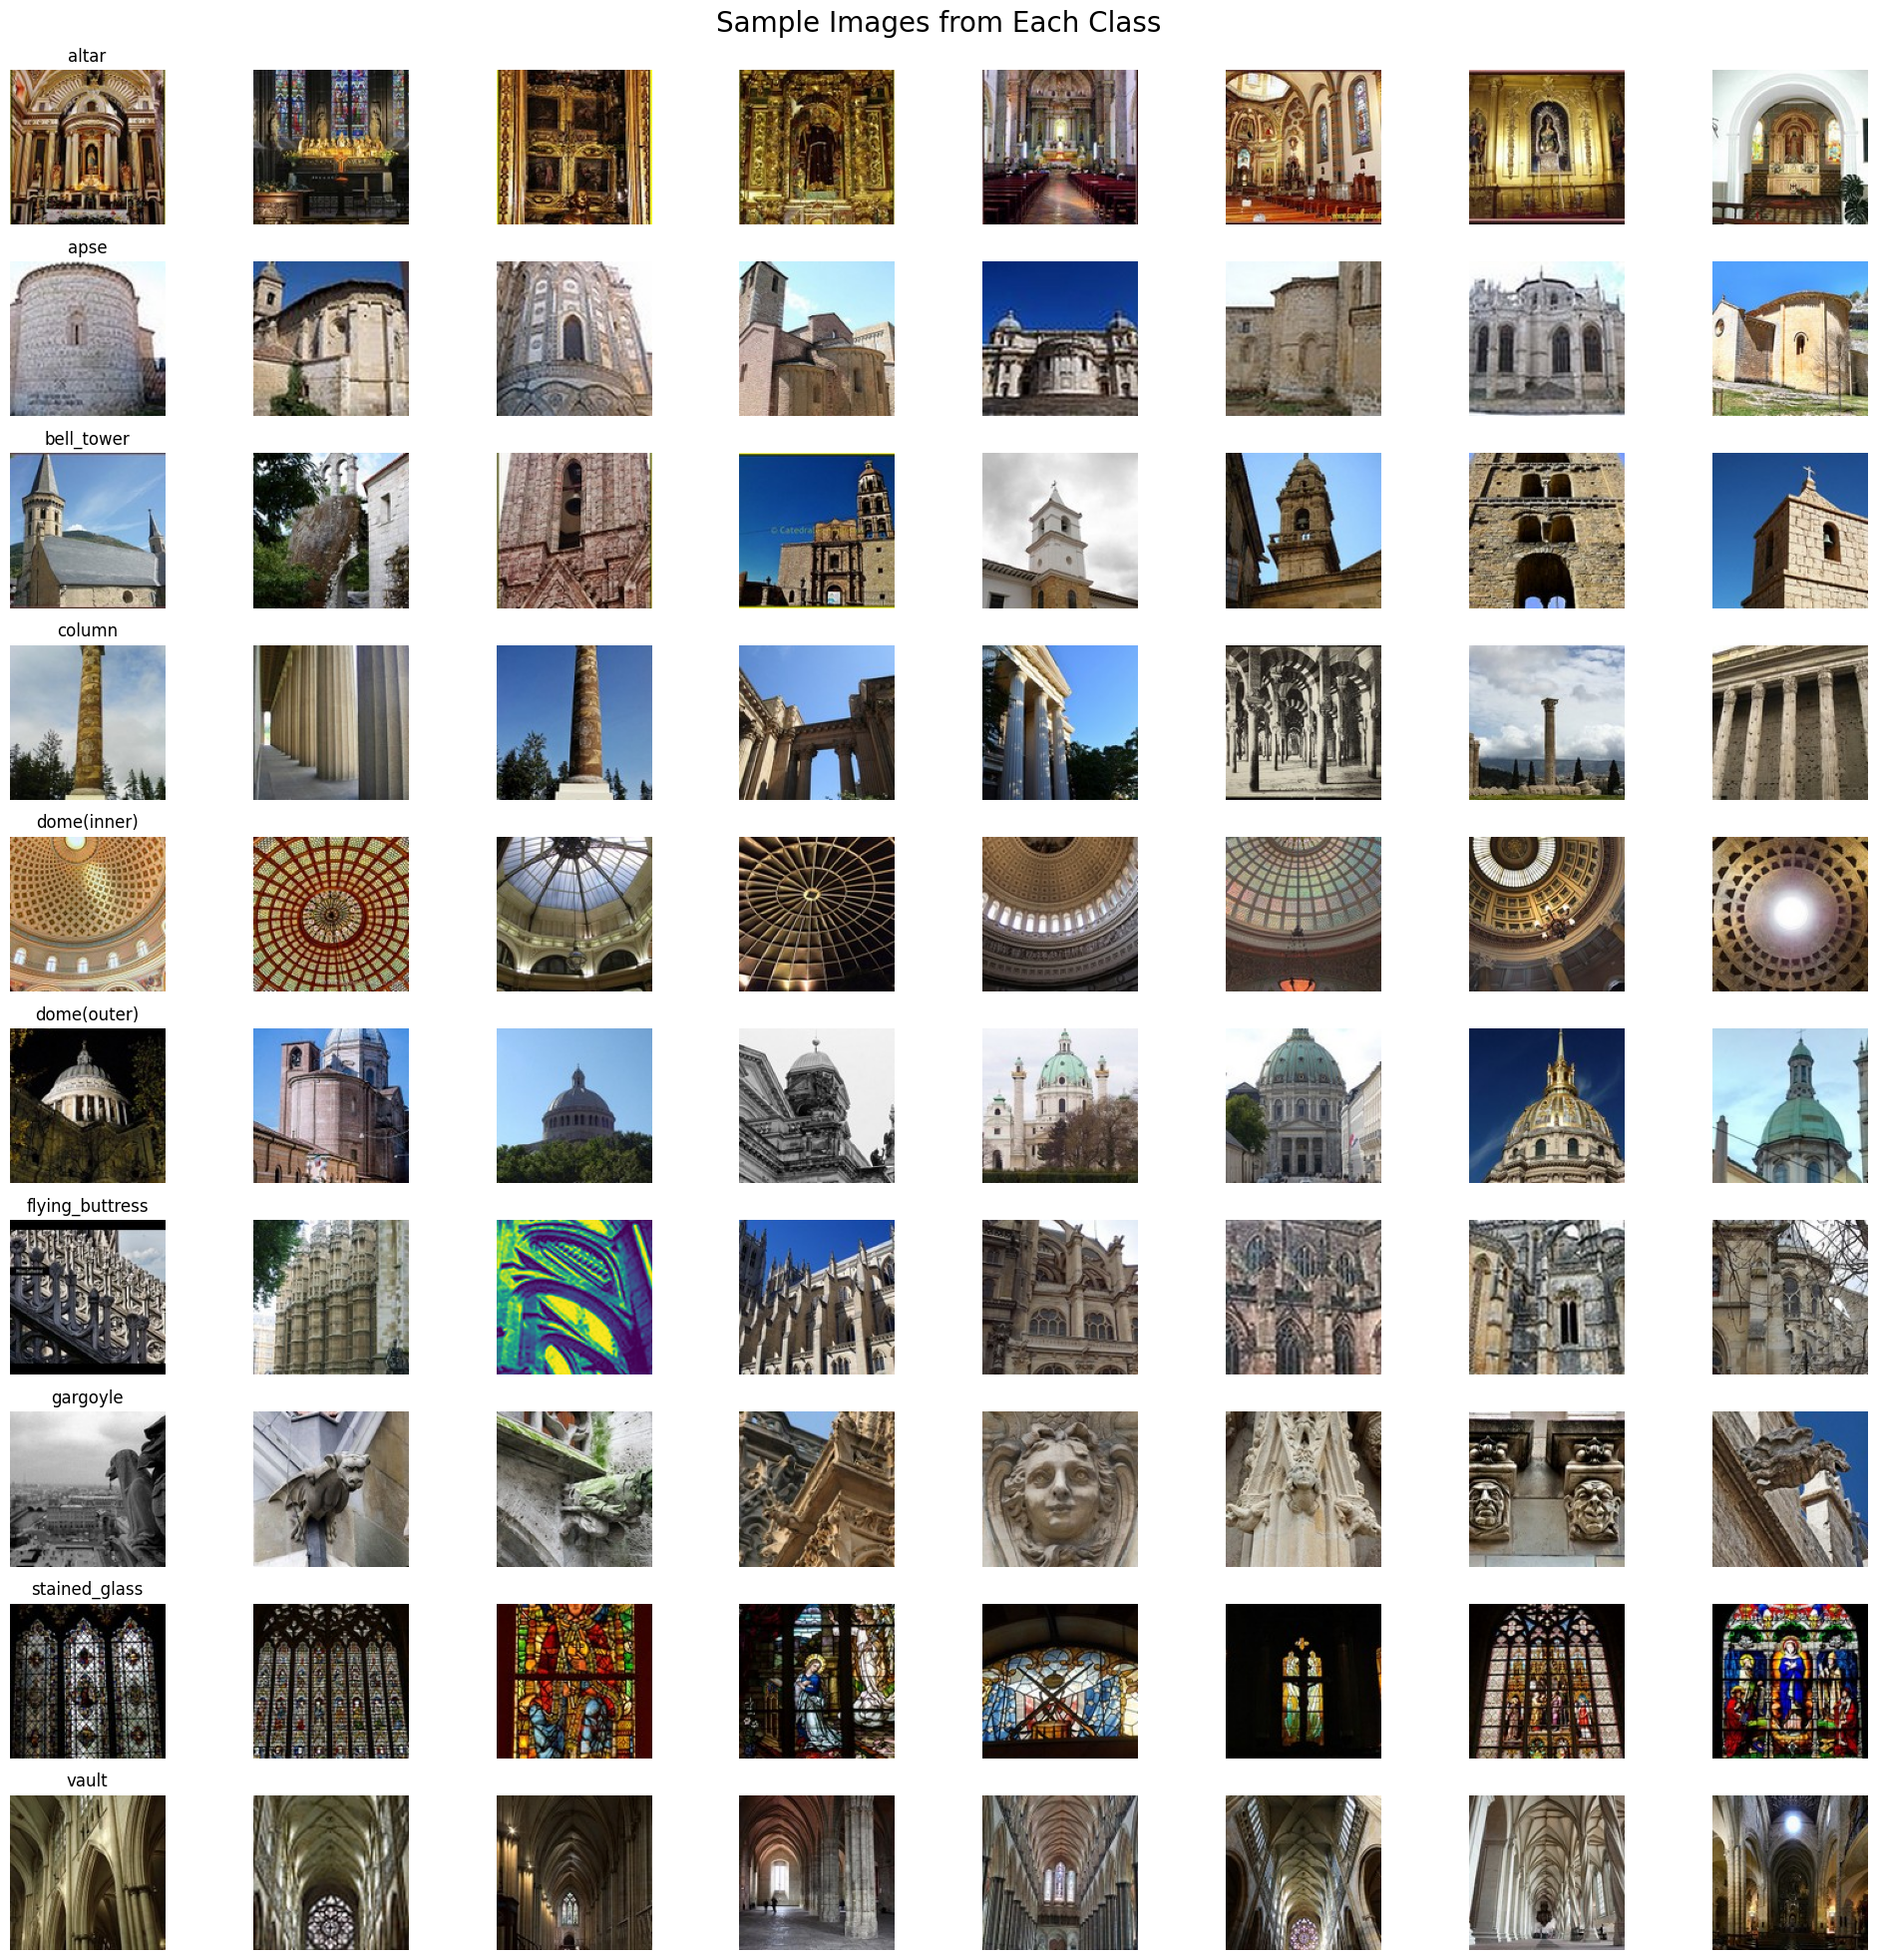

In [17]:
def plot_sample_images(train_dir, labels):
    fig, axes = plt.subplots(nrows=len(labels), ncols=8, figsize=(20, 20))
    fig.suptitle('Sample Images from Each Class', fontsize=20)
    
    for i, label in enumerate(labels):
        label_dir = os.path.join(train_dir, label)
        image_files = os.listdir(label_dir) # Get 8 sample images
        for j, image_file in enumerate(random.sample(image_files, 8)):
            img_path = os.path.join(label_dir, image_file)
            img = plt.imread(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(label, fontsize=12)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

plot_sample_images(train_dir, labels)


## Model configuration

1. Utilize MobilenetV2, a pre-trained model for transfer learning
2. Freeze the parameters of the pre-trained model as they are already optimized for image recognition
3. Add a GlobalAveragePooling2D layer and a dense layer prior to the output layer to predict classes as per our dataset

In [18]:
def create_model(input_shape=(224, 224, 3), num_classes=len(labels)):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(num_classes,activation='softmax')
    ])

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    return model

model = create_model()


## Compile the model

The parameters used are Adam optimizer and loss function is CategoricalCrossEntropy suitable for multi-class classification

In [20]:

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossentropy(),
    metrics=['acc']
)


## Define a callback class to stop training once validation accuracy reaches 95%

The value is kept high so that we are able to observe the overfitting and underfitting trends

In [21]:

class StopTrainingAtAccuracy(tf.keras.callbacks.Callback):
    def __init__(self, target_accuracy):
        super(StopTrainingAtAccuracy, self).__init__()
        self.target_accuracy = target_accuracy

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_acc') >= self.target_accuracy:
            print(f"\nReached {self.target_accuracy * 100}% accuracy, stopping training.")
            self.model.stop_training = True


## Setup dataset directories and count samples (for both training and validation data)

In [22]:
def count_samples(directory, labels):
    samples = {label: len(os.listdir(os.path.join(directory, label))) for label in labels}
    total = sum(samples.values())
    print(f"Sample counts for {directory}: {samples}")
    print(f"Total samples: {total}")
    return samples, total

train_samples, total_train_samples = count_samples(train_dir, labels)
test_samples, total_test_samples = count_samples(test_dir, labels)


Sample counts for HistStruct/Train: {'altar': 829, 'apse': 512, 'bell_tower': 1059, 'column': 1919, 'dome(inner)': 616, 'dome(outer)': 1177, 'flying_buttress': 406, 'gargoyle': 1571, 'stained_glass': 1033, 'vault': 1110}
Total samples: 10232
Sample counts for HistStruct/Test: {'altar': 140, 'apse': 57, 'bell_tower': 170, 'column': 210, 'dome(inner)': 86, 'dome(outer)': 168, 'flying_buttress': 78, 'gargoyle': 240, 'stained_glass': 162, 'vault': 164}
Total samples: 1475


In [23]:

# Image data generators
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)


In [24]:

# Train Data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Test Data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


Found 10232 images belonging to 10 classes.
Found 1475 images belonging to 10 classes.


## Train the model without augmentation

In [25]:
print("\nTraining without augmentation:")
history_no_aug = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=50,
    callbacks=[StopTrainingAtAccuracy(target_accuracy=0.95)]
)



Training without augmentation:
Epoch 1/50


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


320/320 ━━━━━━━━━━━━━━━━━━━━ 28s 67ms/step - acc: 0.8201 - loss: 0.5542 - val_acc: 0.9044 - val_loss: 0.2852
Epoch 2/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - acc: 0.9327 - loss: 0.1974 - val_acc: 0.9220 - val_loss: 0.2609
Epoch 3/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - acc: 0.9499 - loss: 0.1484 - val_acc: 0.9261 - val_loss: 0.2311
Epoch 4/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - acc: 0.9467 - loss: 0.1446 - val_acc: 0.9254 - val_loss: 0.2450
Epoch 5/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - acc: 0.9587 - loss: 0.1192 - val_acc: 0.9261 - val_loss: 0.2615
Epoch 6/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 14s 42ms/step - acc: 0.9567 - loss: 0.1218 - val_acc: 0.9180 - val_loss: 0.3267
Epoch 7/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - acc: 0.9625 - loss: 0.0990 - val_acc: 0.9295 - val_loss: 0.2559
Epoch 8/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - acc: 0.9651 - loss: 0.0950 - val_acc: 0.9268 - val_loss: 0.2742
Epoch 9/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/st

## Train the model with augmentation

In [26]:
train_datagen_aug = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator_aug = train_datagen_aug.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

print("\nTraining with augmentation:")
history_aug = model.fit(
    train_generator_aug,
    validation_data=test_generator,
    epochs=50,
    callbacks=[StopTrainingAtAccuracy(target_accuracy=0.95)]
)


Found 10232 images belonging to 10 classes.

Training with augmentation:
Epoch 1/50


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


320/320 ━━━━━━━━━━━━━━━━━━━━ 103s 314ms/step - acc: 0.8522 - loss: 0.7603 - val_acc: 0.9085 - val_loss: 0.3687
Epoch 2/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 103s 314ms/step - acc: 0.8804 - loss: 0.3808 - val_acc: 0.9180 - val_loss: 0.3437
Epoch 3/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 103s 314ms/step - acc: 0.8865 - loss: 0.3604 - val_acc: 0.9139 - val_loss: 0.3531
Epoch 4/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 102s 313ms/step - acc: 0.9016 - loss: 0.3150 - val_acc: 0.9125 - val_loss: 0.3399
Epoch 5/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 102s 312ms/step - acc: 0.9092 - loss: 0.2821 - val_acc: 0.9085 - val_loss: 0.3348
Epoch 6/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 102s 313ms/step - acc: 0.9060 - loss: 0.2869 - val_acc: 0.9166 - val_loss: 0.3024
Epoch 7/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 103s 314ms/step - acc: 0.9112 - loss: 0.2780 - val_acc: 0.9180 - val_loss: 0.3173
Epoch 8/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 103s 313ms/step - acc: 0.9112 - loss: 0.2762 - val_acc: 0.9241 - val_loss: 0.2982
Epoch 9/50
320/320 ━━━━━━━━━━━━━━━━

## Plot the training and testing validation and accuracy results

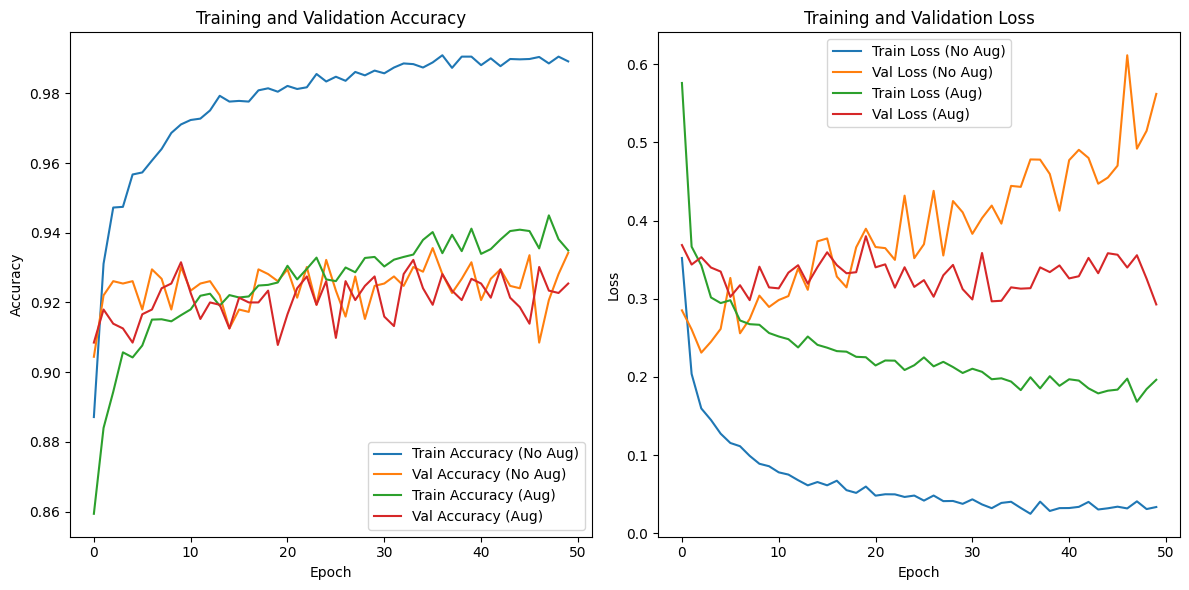

In [27]:
def plot_training_results(history_no_aug, history_aug):
    plt.figure(figsize=(12, 6))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history_no_aug.history['acc'], label='Train Accuracy (No Aug)')
    plt.plot(history_no_aug.history['val_acc'], label='Val Accuracy (No Aug)')
    plt.plot(history_aug.history['acc'], label='Train Accuracy (Aug)')
    plt.plot(history_aug.history['val_acc'], label='Val Accuracy (Aug)')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history_no_aug.history['loss'], label='Train Loss (No Aug)')
    plt.plot(history_no_aug.history['val_loss'], label='Val Loss (No Aug)')
    plt.plot(history_aug.history['loss'], label='Train Loss (Aug)')
    plt.plot(history_aug.history['val_loss'], label='Val Loss (Aug)')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_results(history_no_aug, history_aug)


## Observations

1. The MobilenetV2 model with additional layers works quite well with custom image classification task with accuracy values >90% obtained on validation data
2. When we train the model without augmentation, the training accuracy increases with number of epochs but the change in validation accuracy is smaller in comparison. The test accuracy reaches even 99% which indicates that the model has learned too much from the data
3. This is evidenced by the fact that there is a clear increase in the loss function with increasing number of epochs when augmentation is not used which clearly indicates overfitting.
4. When using augmentation, the model learns slowly epoch by epoch as it is exposed to more variations of the image data in each epoch. The test accuracy is not as high as in the case without augmentation, but the validation accuracy curve is very close to the test accuracy indicating that the model is generalizing well
5. Same can be seen in the loss data where the loss curves for test and train are not too far apart. Hence, this model is expected to perform better as it generalizes better.